In [26]:
import yfinance as yf
import yahoofinancials
import investpy
import pandas as pd
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import date
import datetime as dt
plt.style.use('fivethirtyeight') 
import math 
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten

for the beginning let's study the predicted stock and calculate moving averages

In [27]:
def Stock_SMA(stock,country):
    current_date = str(date.today().day) + '/'+ str(date.today().month) +'/' + str(date.today().year)
    try:
        df = investpy.get_stock_historical_data(stock = stock,country = country,from_date='01/01/2019',to_date=current_date)
    except:
        df = yf.download(stock,start ='2019-01-01',end = date.today(),progress=False)
    #Count SMA30 / SMA90
    SMA30 = pd.DataFrame()
    SMA30['Close Price'] = df['Close'].rolling(window = 30).mean()
    SMA90 = pd.DataFrame()
    SMA90['Close Price'] = df['Close'].rolling(window = 90).mean()
    data = pd.DataFrame()
    data['Stock'] = df['Close']
    data['SMA30'] = SMA30['Close Price']
    data['SMA90'] = SMA90['Close Price']
     
    plt.figure(figsize = (12.6,4.6))
    plt.plot(data['Stock'], label = stock ,alpha = 0.35)
    plt.plot(SMA30['Close Price'], label = 'SMA30',alpha = 0.35)
    plt.plot(SMA90['Close Price'], label = 'SMA90',alpha = 0.35)
    plt.title(stock + ' history (SMA)')
    plt.xlabel('01/01/2019 - '+ current_date)
    plt.ylabel('Close price')
    plt.legend(loc = 'upper left')
    plt.show()
    
def Stock_EMA(stock,country):
    current_date = str(date.today().day) + '/'+ str(date.today().month) +'/' + str(date.today().year)
    try:
        df = investpy.get_stock_historical_data(stock = stock,country = country,from_date='01/01/2019',to_date=current_date)
    except:
        df = yf.download(stock,start ='2019-01-01',end = date.today(),progress=False)
    #Count EMA20 / EMA60
    EMA20 = pd.DataFrame()
    EMA20['Close Price'] = df['Close'].ewm(span=20).mean()
    EMA60 = pd.DataFrame()
    EMA60['Close Price'] = df['Close'].ewm(span=60).mean()
    data = pd.DataFrame()
    data['Stock'] = df['Close']
    data['EMA20'] = EMA20['Close Price']
    data['EMA60'] = EMA60['Close Price']
 
    plt.figure(figsize = (12.6,4.6))
    plt.plot(data['Stock'], label = stock ,alpha = 0.35)
    plt.plot(EMA20['Close Price'], label = 'EMA30',alpha = 0.35)
    plt.plot(EMA60['Close Price'], label = 'EMA60',alpha = 0.35)
    plt.title(stock + ' history (EMA)')
    plt.xlabel('01/01/2019 - '+ current_date)
    plt.ylabel('Close price')
    plt.legend(loc = 'upper left')
    plt.show()

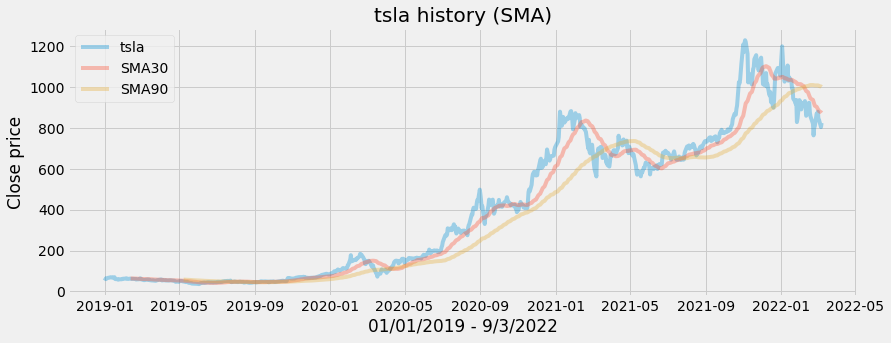

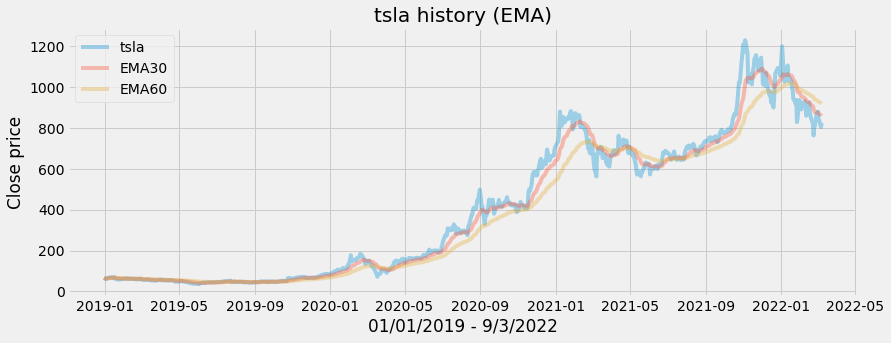

In [28]:
# Подставьте данные для получения визуализации
stock = 'tsla'
country = 'usa'

Stock_SMA(stock,country)
Stock_EMA(stock,country)

In [29]:
tesla = investpy.get_stock_historical_data(stock='tsla',
                                        country='United States',
                                        from_date='01/01/2019',
                                        to_date='07/03/2022')
tesla

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2019-01-02,61.22,63.03,59.76,62.02,58293240,USD
2019-01-03,61.40,61.88,59.48,60.07,34825920,USD
2019-01-04,61.20,63.60,60.55,63.54,36970580,USD
2019-01-07,64.34,67.35,63.55,66.99,37756124,USD
2019-01-08,68.39,68.80,65.40,67.07,35042580,USD
...,...,...,...,...,...,...
2022-03-01,869.68,889.88,853.78,864.37,24717400,USD
2022-03-02,872.13,886.48,844.27,879.89,24651700,USD
2022-03-03,878.77,886.44,832.60,839.29,20256000,USD


In [30]:
#Creating a new dataframe with only the column "Close"
data = tesla.filter(['Close'])
dataset = data.values

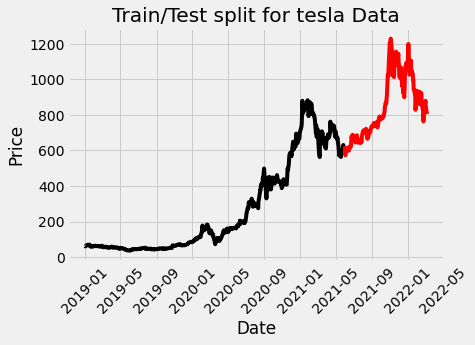

In [31]:
train = data[data.index < pd.to_datetime("2021-06-01", format='%Y-%m-%d')]
test = data[data.index >= pd.to_datetime("2021-06-01", format='%Y-%m-%d')]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for tesla Data")
plt.show()

In [32]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [33]:
#Create a training data set that contains the past 60 day closing price values 
#that we want to use to predict the 61st closing price value.
train_data = scaled_data[:len(train)]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])

In [34]:
#convert x_train и y_train in numpy massive
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],x_train.shape[2]))

In [35]:
#create test dataset
test_data = scaled_data[len(train) - 60:]
x_test = []
y_test = dataset[len(train):]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i])

In [36]:
#convert in numpy massive again
x_test = np.array(x_test)
#reshape data again
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2]))

In [37]:
#first NN
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam',loss = 'mean_squared_error')

model.fit(x_train,y_train,batch_size = 1, epochs = 10)

Epoch 1/10
547/547 [==============================] - 12s 17ms/step - loss: 0.0033
Epoch 2/10
547/547 [==============================] - 9s 16ms/step - loss: 0.0014
Epoch 3/10
547/547 [==============================] - 9s 16ms/step - loss: 0.0011
Epoch 4/10
547/547 [==============================] - 9s 16ms/step - loss: 7.5340e-04
Epoch 5/10
547/547 [==============================] - 9s 16ms/step - loss: 6.5207e-04
Epoch 6/10
547/547 [==============================] - 9s 16ms/step - loss: 7.5682e-04
Epoch 7/10
547/547 [==============================] - 9s 16ms/step - loss: 7.2717e-04
Epoch 8/10
547/547 [==============================] - 9s 16ms/step - loss: 5.4159e-04
Epoch 9/10
547/547 [==============================] - 9s 16ms/step - loss: 5.1932e-04
Epoch 10/10
547/547 [==============================] - 9s 16ms/step - loss: 4.8391e-04


In [38]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

MSE_error = mean_squared_error(y_test, y_pred)
print('Testing Mean Squared Error is {}'.format(MSE_error))
MAE_error = mean_absolute_error(y_test, y_pred)
print('Testing Absolute Squared Error is {}'.format(MAE_error))

Testing Mean Squared Error is 1471.635767556815
Testing Absolute Squared Error is 25.894747440298808


In [39]:
test['Predictions_1'] = y_pred
test

,Close,Predictions_1
Date,,
2021-06-01,623.90,631.627686
2021-06-02,605.12,629.889160
2021-06-03,572.84,617.636414
2021-06-04,599.05,592.581787
2021-06-07,605.13,594.805420
...,...,...
2022-03-01,864.37,834.428223
2022-03-02,879.89,852.633606
2022-03-03,839.29,866.752625


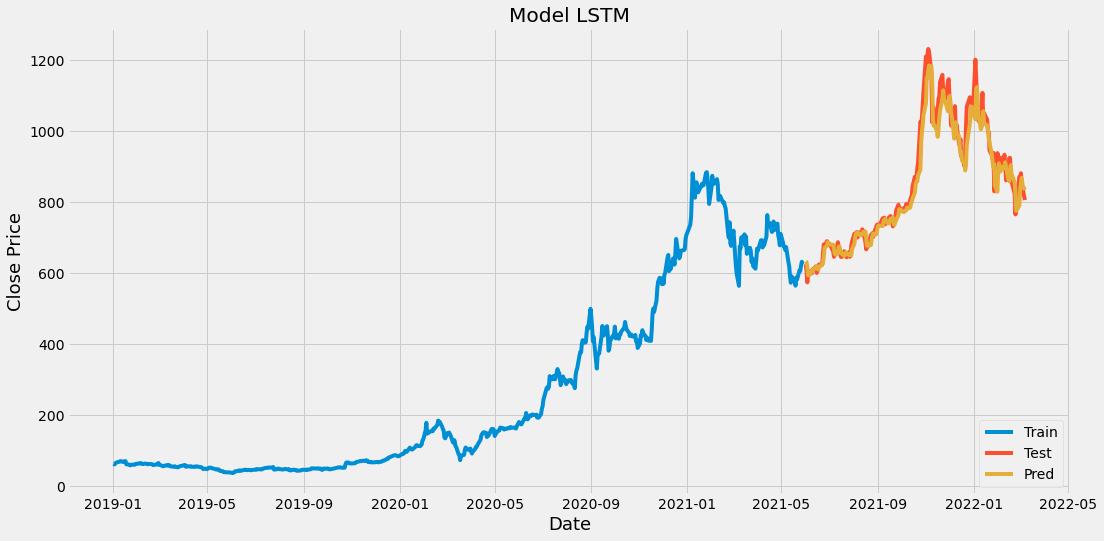

In [40]:
plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price',fontsize = 18)
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions_1']])
plt.legend(['Train','Test','Pred'], loc = 'lower right')
plt.show()

In [43]:
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()
regressor.add(LSTM(50, activation='relu', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(50, return_sequences = True, activation='relu'))
regressor.add(Dropout(0.2))
regressor.add(LSTM(50, return_sequences = False))
regressor.add(Flatten()) 
regressor.add(Dense(1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(x_train, y_train, epochs = 10, batch_size = 1)

Epoch 1/10
547/547 [==============================] - 18s 27ms/step - loss: 0.0070
Epoch 2/10
547/547 [==============================] - 13s 24ms/step - loss: 0.0024
Epoch 3/10
547/547 [==============================] - 14s 25ms/step - loss: 0.0024
Epoch 4/10
547/547 [==============================] - 13s 24ms/step - loss: 0.0018
Epoch 5/10
547/547 [==============================] - 14s 25ms/step - loss: 0.0017
Epoch 6/10
547/547 [==============================] - 13s 25ms/step - loss: 0.0019
Epoch 7/10
547/547 [==============================] - 14s 25ms/step - loss: 0.0017
Epoch 8/10
547/547 [==============================] - 14s 25ms/step - loss: 0.0016
Epoch 9/10
547/547 [==============================] - 14s 25ms/step - loss: 0.0014
Epoch 10/10
547/547 [==============================] - 14s 25ms/step - loss: 0.0012


In [44]:
#Получаем модель предсказывающую значения
y_pred2 = regressor.predict(x_test)
y_pred2 = scaler.inverse_transform(y_pred2)

MSE_error = mean_squared_error(y_test, y_pred2)
print('Testing Mean Squared Error is {}'.format(MSE_error))
MAE_error = mean_absolute_error(y_test, y_pred2)
print('Testing Absolute Squared Error is {}'.format(MAE_error))

Testing Mean Squared Error is 11224.88411277532
Testing Absolute Squared Error is 75.23137205772792


In [45]:
test['Predictions_2'] = y_pred2
test

,Close,Predictions_1,Predictions_2
Date,,,
2021-06-01,623.90,631.627686,629.616821
2021-06-02,605.12,629.889160,637.799194
2021-06-03,572.84,617.636414,643.678101
2021-06-04,599.05,592.581787,645.122986
2021-06-07,605.13,594.805420,644.610962
...,...,...,...
2022-03-01,864.37,834.428223,785.686890
2022-03-02,879.89,852.633606,783.958862
2022-03-03,839.29,866.752625,786.557495


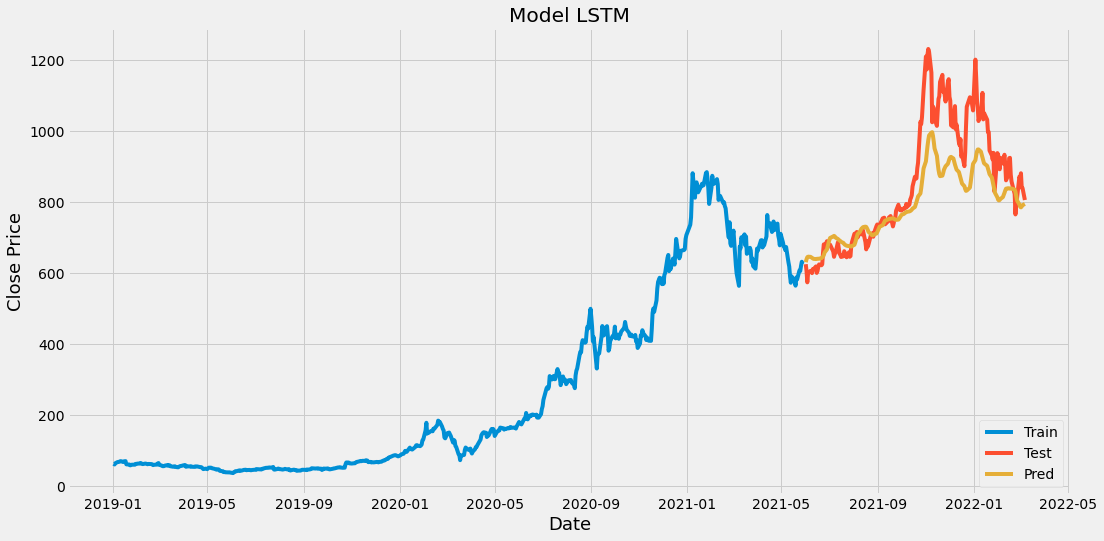

In [46]:
plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price',fontsize = 18)
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions_2']])
plt.legend(['Train','Test','Pred'], loc = 'lower right')
plt.show()

In [47]:
abs_error = []
for i in range(len(x_test)):
    diff = abs(test.Predictions_1[i] - test.Close[i])
    abs_error.append(diff)
test['Absolute Error'] = abs_error
test[-5:]

,Close,Predictions_1,Predictions_2,Absolute Error
Date,,,,
2022-03-01,864.37,834.428223,785.686890,29.941777
2022-03-02,879.89,852.633606,783.958862,27.256394
2022-03-03,839.29,866.752625,786.557495,27.462625
2022-03-04,838.29,846.032349,790.108582,7.742349
2022-03-07,804.58,833.037415,793.608398,28.457415


In [48]:
#Get teh last 60 day closing price 
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

x_test = []
x_test.append(last_60_days_scaled)
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [49]:
#Get the predicted scaled price
pred_price = model.predict(x_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print('The predicted price for 08/03/22:', pred_price)

The predicted price for 08/03/22: [[807.449]]
